In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

In [18]:
beer=pd.read_csv('train1.csv')

In [19]:
display(beer[:1].head())

,index,beer/ABV,beer/beerId,beer/brewerId,beer/name,beer/style,review/appearance,review/aroma,review/overall,review/palate,review/taste,review/text,review/timeStruct,review/timeUnix,user/ageInSeconds,user/birthdayRaw,user/birthdayUnix,user/gender,user/profileName
0,40163,5.0,46634,14338,Chiostro,Herbed / Spiced Beer,4.0,4.0,4.0,4.0,4.0,Pours a clouded gold with a thin white head. N...,"{'min': 38, 'hour': 3, 'mday': 16, 'sec': 10, ...",1229398690,NaN,NaN,NaN,NaN,RblWthACoz


In [26]:
reviews = beer['review/overall']

for review in ['review/aroma', 'review/appearance', 'review/palate', 'review/taste']:
    reviews = pd.merge(reviews, beer[review],left_index=True, right_index=True)

In [27]:
reviews = reviews.dropna()
reviews.head()

,review/overall,review/aroma,review/appearance,review/palate,review/taste
0,4.0,4.0,4.0,4.0,4.0
1,3.5,3.5,4.0,3.5,3.0
2,3.5,4.0,3.5,3.5,3.5
3,2.5,3.0,3.0,3.0,3.0
4,3.0,3.0,4.0,3.5,2.5


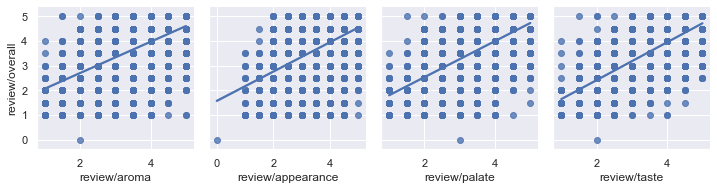

In [28]:
sns.pairplot(reviews, x_vars=['review/aroma', 'review/appearance', 'review/palate', 'review/taste'], 
             y_vars=['review/overall'], kind='reg')

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor

X = reviews[['review/aroma', 'review/appearance','review/palate', 'review/taste']]
y = reviews['review/overall']

In [32]:
kfold = KFold(n_splits=10, shuffle=True)

data_sets = dict()
for split in range(10):
    _d = dict()
    for train_idx, test_idx in kfold.split(X):
        _d.update({
                'X_train' : X.iloc[train_idx],
                'X_test': X.iloc[test_idx],
                'y_train': y.iloc[train_idx],
                'y_test': y.iloc[test_idx]
            })
    data_sets.update({
            split : _d
        })

In [33]:
from sklearn import metrics

class Regression:
    def __init__(self, regressor):
        self.regressor = regressor
        
    def fit(self, X, y):
        self.regressor.fit(X, y) 

    def predict(self, X, y):
        return self.regressor.predict(X)
    
    def score(self, X, y):
        return self.regressor.score(X, y)

    def mean_squared_error(self, X, y):
        return metrics.mean_squared_error(self.predict(X,y), y)
    
    def accuracy(self, X,y):
        return metrics.r2_score(self.predict(X,y), y)

In [34]:
def model_fit(data_set, regressor):
    params = dict()
    regressor.fit(data_set['X_train'], data_set['y_train'])
    neighbors = True if 'neighbors' in regressor.regressor.steps[1][0] else False
    params.update({
            'coeffs' : [0.0] if neighbors else regressor.regressor.steps[1][1].coef_,
            'intercept': [0.0] if neighbors else regressor.regressor.steps[1][1].intercept_,
            'mean_sq_error': regressor.mean_squared_error(data_set['X_train'], data_set['y_train']),
            'accuracy': regressor.accuracy(data_set['X_test'], data_set['y_test'])
        })
    #print (params)
    return params
    
def compute_averages(list_of_dicts):
    averaged_params = dict()
    for set_key in list_of_dicts[0].keys():
        _list = [val for obj in list_of_dicts for key, val in obj.items() if key == set_key]
        if isinstance(_list[0], dict):
            averaged_params[set_key] = compute_averages(_list)
        elif isinstance(_list[0], list) or isinstance(_list[0], np.ndarray):
            if isinstance(_list[0][0], dict):
                sub_list = [[_list[i][j] for i in range(len(_list))] for j in range(len(_list[0]))]
                averaged_params[set_key] = [compute_averages(x) for x in sub_list]
            else:
                averaged_params[set_key] = np.round(np.average(np.array(_list), axis=0), 3)
        elif isinstance(_list[0], float) or isinstance(_list[0], int):
            averaged_params[set_key] = np.round(np.average(np.array(_list)), 3)
        else:
            pass
    return averaged_params

def averaged_params(regressor):
    multiple_params = list()
    for set_key, value in data_sets.items():
        multiple_params.append({
                set_key: model_fit(value, regressor)
            })
    return compute_averages(multiple_params)

In [ ]:
##Linear Regression

In [36]:
linear = make_pipeline(StandardScaler(), LinearRegression(fit_intercept=True))
regressor = Regression(linear)
averaged_params(regressor)

{0: {'coeffs': array([0.04 , 0.033, 0.163, 0.386]),
  'intercept': 3.889,
  'mean_sq_error': 0.171,
  'accuracy': 0.471}}

In [37]:
##Lasso Regression

In [39]:
for alpha in [1.0, 0.1, 0.01, 0.001]:
    lasso = make_pipeline(StandardScaler(), Lasso(alpha=alpha, fit_intercept=True))
    regressor = Regression(lasso)
    print ("Lasso: alpha = ", alpha)
    print (averaged_params(regressor))

Lasso: alpha =  1.0
{0: {'coeffs': array([0., 0., 0., 0.]), 'intercept': 3.889, 'mean_sq_error': 0.491, 'accuracy': -1.5351416147331998e+29}}
Lasso: alpha =  0.1
{0: {'coeffs': array([0.   , 0.   , 0.124, 0.36 ]), 'intercept': 3.889, 'mean_sq_error': 0.184, 'accuracy': 0.121}}
Lasso: alpha =  0.01
{0: {'coeffs': array([0.036, 0.028, 0.159, 0.384]), 'intercept': 3.889, 'mean_sq_error': 0.171, 'accuracy': 0.449}}
Lasso: alpha =  0.001
{0: {'coeffs': array([0.04 , 0.032, 0.162, 0.386]), 'intercept': 3.889, 'mean_sq_error': 0.171, 'accuracy': 0.469}}


In [40]:
##KNeighbors Regression

In [41]:
for neighbors in range(1,10):
    kneighbors = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=neighbors))
    regressor = Regression(kneighbors)
    print ("KNeighbors: neighbors = ", neighbors)
    print (averaged_params(regressor))

KNeighbors: neighbors =  1
{0: {'coeffs': array([0.]), 'intercept': array([0.]), 'mean_sq_error': 0.298, 'accuracy': 0.323}}
KNeighbors: neighbors =  2
{0: {'coeffs': array([0.]), 'intercept': array([0.]), 'mean_sq_error': 0.226, 'accuracy': 0.384}}
KNeighbors: neighbors =  3
{0: {'coeffs': array([0.]), 'intercept': array([0.]), 'mean_sq_error': 0.204, 'accuracy': 0.399}}
KNeighbors: neighbors =  4
{0: {'coeffs': array([0.]), 'intercept': array([0.]), 'mean_sq_error': 0.189, 'accuracy': 0.435}}
KNeighbors: neighbors =  5
{0: {'coeffs': array([0.]), 'intercept': array([0.]), 'mean_sq_error': 0.18, 'accuracy': 0.447}}
KNeighbors: neighbors =  6
{0: {'coeffs': array([0.]), 'intercept': array([0.]), 'mean_sq_error': 0.18, 'accuracy': 0.453}}
KNeighbors: neighbors =  7
{0: {'coeffs': array([0.]), 'intercept': array([0.]), 'mean_sq_error': 0.178, 'accuracy': 0.451}}
KNeighbors: neighbors =  8
{0: {'coeffs': array([0.]), 'intercept': array([0.]), 'mean_sq_error': 0.178, 'accuracy': 0.454}}
KN